# Introduction

## Import and settings

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.special import expit

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import networkx as nx

from lingam.causal_based_simulator import CausalBasedSimulator

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Creatig test data
The test data X is a data frame such that only x2 is a categorical variable and the other variables are continuous variables. x2 has either "a" or "b" as a category value.  
The matrix G of the causal graph is needed to estimate the functional relationship in CausalBasedSimulator. Although the elements are numeric to generate test data, CausalBasedSimulator ignores the volume and uses only zero or nonzero.

### Causal graph

array([[0. , 0. , 0. , 3. , 0. , 0. ],
       [3. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ],
       [8. , 0. , 1. , 0. , 0. , 0. ],
       [4. , 0. , 0. , 0. , 0. , 0. ]])

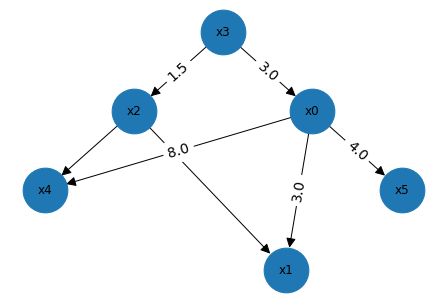

### Test data

,x0,x1,x2,x3,x4,x5
0,2.457959,3.979581,b,0.548814,10.245798,10.198616
1,2.621652,8.431475,a,0.715189,21.602835,10.784233
2,2.331446,7.131753,a,0.602763,19.430153,9.394384
3,1.885170,3.177467,b,0.544883,8.392238,7.893208
4,1.876007,5.681239,a,0.423655,15.824472,7.736226
...,...,...,...,...,...,...
995,1.234716,2.070230,b,0.097676,5.288504,5.043098
996,2.090899,3.371803,b,0.514922,8.798471,8.503125
997,3.138850,9.613938,a,0.938412,25.940801,13.251922
998,1.499485,2.647914,b,0.228647,6.930745,6.481635


In [2]:
display(Markdown("### Causal graph"))

G = np.array([[0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [3.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.5, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

display(G)

graph = nx.DiGraph()

graph.add_node("x0", pos=(3, 1))
graph.add_node("x1", pos=(2.7, -1))
graph.add_node("x2", pos=(1, 1))
graph.add_node("x3", pos=(2, 2))
graph.add_node("x4", pos=(0, 0))
graph.add_node("x5", pos=(4, 0))

edges = []
edge_labels = {}
for to, from_ in np.argwhere(~np.isclose(G, 0)):
    edges.append((f"x{from_}", f"x{to}"))
    if from_ == 2:
        continue
    edge_labels[(f"x{to}", f"x{from_}")] = G[to, from_]
graph.add_edges_from(edges)
pos = nx.get_node_attributes(graph, "pos")
nx.draw(graph, pos, with_labels=True, arrowsize=20, node_size=2000)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)
plt.show() 

display(Markdown("### Test data"))

N = 1000

X = {}

X["x3"] = np.random.uniform(size=N)

X["x2"] = np.empty(N).astype(str)
for i in range(N):
    prob_a = expit(G[2, 3] * X["x3"][i] - 0.5)
    X["x2"][i] = np.random.choice(["a", "b"], p=[prob_a, 1 - prob_a])

X["x0"] = G[0, 3] * X["x3"] + np.random.uniform(size=N)

X["x4"] = np.empty(N)
for i in range(N):
    if X["x2"][i] == "a":
        X["x4"][i] = 8.0 * X["x0"][i] + np.random.uniform()
    elif X["x2"][i] == "b":
        X["x4"][i] = 4.0 * X["x0"][i] + np.random.uniform()

X["x1"] = np.empty(N)
for i in range(N):
    if X["x2"][i] == "a":
        X["x1"][i] = 3.0 * X["x0"][i] + np.random.uniform()
    elif X["x2"][i] == "b":
        X["x1"][i] = 1.5 * X["x0"][i] + np.random.uniform()

X["x5"] = G[5, 0] * X["x0"] + np.random.uniform(size=1000)

X = pd.DataFrame(X)
X["x2"] = X["x2"].astype("category")
X = X[sorted(X.columns)]

display(X)

## Estimating functional relationships between variables

Estimate functional relationships between variables by feeding test data to CausalBasedSimulator.

See the notebook *estimating_functional_felationships.ipynb* for more information.

In [3]:
sim = CausalBasedSimulator()
sim.train(X, G)

Functional relationships between variables are stored in train_result_. The keys of the dictionary are the column names of X given to train().

In [4]:
sim.train_result_.keys()

dict_keys(['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

The values of each variable is cotained in a list.  
If a categorical variable is present in the parent, the child will have a separate machine learning model for each value of the parent. For example, x1, whose parent is the categorical variable x2, will have two machine learning models because the parent has two possible values, a or b. Thus, each variable has multiple machine learning models, so we have a list for each variable.

In [5]:
print(type(sim.train_result_["x1"]))
print(len(sim.train_result_["x1"]))

<class 'list'>
2


There are five elements of the list
- Conditions for applying the model created by the parent values
- Instances of the machine learning model
- Explanatory variables of the machine learning model
- Predictions for the training data X
- Residuals of predictions for training data X

In [6]:
print(sim.train_result_["x1"][0].keys())

dict_keys(['condition', 'model', 'exp_columns', 'predicted', 'residual'])


Since x1 has two instances of the machine learning model, let's review the conditions for each.

In [7]:
print(sim.train_result_["x1"][0]["condition"])
print(sim.train_result_["x1"][1]["condition"])

{'x2': 'a'}
{'x2': 'b'}


If the models argument is specified at train() and no machine learning model is specified, sklearn.linear_model.LinearRegression is used if the variable is a continuous variable, or LogisticRegression if the variable is a categorical variable. (However, if there are no explanatory variables because the parents are all categorical variables, a special machine learning model is used.)

We also check the parameters of each machine learning model instance.

In [8]:
model = sim.train_result_["x1"][0]["model"]
print(model, model.coef_, model.intercept_)
model = sim.train_result_["x1"][1]["model"]
print(model, model.coef_, model.intercept_)

LinearRegression() [3.001] 0.4948594354078173
LinearRegression() [1.484] 0.5067806444646545


The residuals for the training data can also be checked as follows. The categorical variable is set to NaN because the residuals cannot be calculated because a classification model is used and the most upstream variables are set to NaN because have no model.

In [9]:
sim.residual_

,x0,x1,x2,x3,x4,x5
0,0.307648,-0.174462,NaN,NaN,-0.057256,-0.125786
1,-0.022822,0.068330,NaN,NaN,0.142083,-0.194651
2,0.020896,-0.360406,NaN,NaN,0.292654,-0.424192
3,-0.253467,-0.126638,NaN,NaN,0.370783,-0.141057
4,0.097439,-0.444025,NaN,NaN,0.333002,-0.261405
...,...,...,...,...,...,...
995,0.424357,-0.268694,NaN,NaN,-0.141988,-0.390509
996,0.041252,-0.237576,NaN,NaN,-0.042469,-0.353691
997,-0.168632,-0.301457,NaN,NaN,0.339606,0.205167
998,0.300122,-0.083889,NaN,NaN,0.445596,-0.010574


## Generating simulated data

In CausalBasedSimulator with train() already done, replace the model representing the exogenous variables and variable relationships for each variable, and then simulationaly generate the data.

For more information, see the notebook *generating_simulated_data.ipynb*.

In [10]:
# new x0 data
changing_exog = {
    "x0": np.random.laplace(0, 10, size=X.shape[0]),
}

# new x5 model
# explanatories are listed in train_result_
new_model = LinearRegression()
new_model.fit(X[sim.train_result_["x5"][0]["exp_columns"]].values, X["x5"] * 10)

changing_models = [
    {
        # the target variable name
        "name": "x5",
        # codition of the target model 
        "condition": sim.train_result_["x5"][0]["condition"],
        # new instance of the model
        "model": new_model,
    }
]

sim_df = sim.run(changing_exog=changing_exog, changing_models=changing_models)

Check the data generated counterfactually.

In [11]:
sim_df

,x0,x1,x2,x3,x4,x5
0,4.420822,13.588479,a,0.548814,35.806811,181.597877
1,2.918888,9.323561,a,0.715189,23.982369,121.478354
2,10.617982,15.901951,b,0.602763,43.099660,429.075691
3,17.017762,51.443119,a,0.544883,137.080054,685.236238
4,-53.376615,-160.146793,a,0.423655,-426.502161,-2129.407660
...,...,...,...,...,...,...
995,19.542237,29.235988,b,0.097676,78.213143,785.920890
996,23.471483,70.701539,a,0.514922,188.332271,943.057699
997,12.562219,37.896011,a,0.938412,101.379882,507.439940
998,2.014600,3.412272,b,0.228647,8.982612,85.506974


The generated data can also be viewed as follows

In [12]:
sim.simulated_data_

,x0,x1,x2,x3,x4,x5
0,4.420822,13.588479,a,0.548814,35.806811,181.597877
1,2.918888,9.323561,a,0.715189,23.982369,121.478354
2,10.617982,15.901951,b,0.602763,43.099660,429.075691
3,17.017762,51.443119,a,0.544883,137.080054,685.236238
4,-53.376615,-160.146793,a,0.423655,-426.502161,-2129.407660
...,...,...,...,...,...,...
995,19.542237,29.235988,b,0.097676,78.213143,785.920890
996,23.471483,70.701539,a,0.514922,188.332271,943.057699
997,12.562219,37.896011,a,0.938412,101.379882,507.439940
998,2.014600,3.412272,b,0.228647,8.982612,85.506974
